# Twitter Example
In order to use all of this though, we need to setup a Developer API account with Twitter and create an application to get credentials. 

    https://apps.twitter.com/
    
Once you have that you also need to install python-twitter, a python library to connect your Python to the twitter dev account.

You probably won't be able to run this example and then previous in the same notebook, you need to restart you kernel.

Let's get started!

Begin by running the TweetRead.py file. Make sure to add your own IP Adress and your credential keys.

In [1]:
import findspark

In [2]:
findspark.init('/home/myspark/spark-2.1.0-bin-hadoop2.7')

In [3]:
import pyspark

In [4]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc # Allow us to order things in decscending order

In [5]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [7]:
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc) # Allow us to use SQL to qeury

In [8]:
socket_stream = ssc.socketTextStream("127.0.0.1", 9992)

In [9]:
lines = socket_stream.window( 20 )

In [10]:
from collections import namedtuple # Each element will be assigned a field
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [11]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word, sets up a tuple
  .reduceByKey( lambda a, b: a + b ) # Reduces by key
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts in descendoing order by count
  .limit(10).registerTempTable("tweets") ) ) # For every ten tweets is will be egistered as a table.

In [12]:
ssc.start()   

In [13]:
import time
from IPython import display # Enables us to show stuff in the notebook
import matplotlib.pyplot as plt #Visualization library
import seaborn as sns # Visualization library
# Only works for Jupyter Notebooks!
# The following code enables us to view the bar plot within a cell in the jupyter notebook
%matplotlib inline

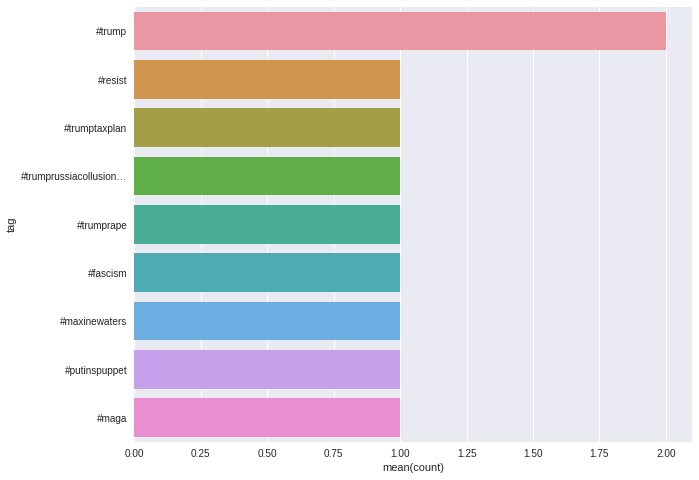

In [14]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas() # Dataframe library
    display.clear_output(wait=True) #Clears the output, if a plot exists.
    sns.plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    sns.plt.show()
    count = count + 1

In [14]:
ssc.stop()